# Stable Baselines3 Tutorial - Getting Started

In this notebook, we will go over the basics for using stable baselines library: how to create a RL model, train it and evaluate it. Because all algorithms share the same interface, we will see how simple it is to switch from one algorithm to another.


## Install Dependencies and Stable Baselines3 Using Pip

List of full dependencies can be found in the [README](https://github.com/DLR-RM/stable-baselines3).


```
pip install stable-baselines3[extra]
```

In [1]:
%%capture
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!apt install swig
!pip install "stable-baselines3[extra]>=2.0.0a4"
!pip install gymnasium[box2d]

# Stablebaseline

## Imports

Stable-Baselines3 works on environments that follow the [gym interface](https://stable-baselines3.readthedocs.io/en/master/guide/custom_env.html).
You can find a list of available environment [here](https://gymnasium.farama.org/environments/classic_control/).

Not all algorithms can work with all action spaces, you can find more in this [recap table](https://stable-baselines3.readthedocs.io/en/master/guide/algos.html)

In [2]:
import gymnasium as gym
import numpy as np

The first thing you need to import is the RL model, check the documentation to know what you can use on which problem

In [3]:
from stable_baselines3 import PPO, A2C, SAC, TD3

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The next thing you need to import is the policy class that will be used to create the networks (for the policy/value functions).
This step is optional as you can directly use strings in the constructor:

```PPO('MlpPolicy', env)``` instead of ```PPO(MlpPolicy, env)```

Note that some algorithms like `SAC` have their own `MlpPolicy`, that's why using string for the policy is the recommended option.

In [4]:
from stable_baselines3.ppo.policies import MlpPolicy

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Create the Gym env and instantiate the agent

For this example, we will use CartPole environment, a classic control problem.

"A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. "

Cartpole environment: [https://gymnasium.farama.org/environments/classic_control/cart_pole/](https://gymnasium.farama.org/environments/classic_control/cart_pole/)

![Cartpole](https://cdn-images-1.medium.com/max/1143/1*h4WTQNVIsvMXJTCpXm_TAw.gif)


We chose the MlpPolicy because the observation of the CartPole task is a feature vector, not images.

The type of action to use (discrete/continuous) will be automatically deduced from the environment action space

Here we are using the [Proximal Policy Optimization](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html) algorithm, which is an Actor-Critic method: it uses a value function to improve the policy gradient descent (by reducing the variance).

It combines ideas from [A2C](https://stable-baselines3.readthedocs.io/en/master/modules/a2c.html) (having multiple workers and using an entropy bonus for exploration) and [TRPO](https://stable-baselines.readthedocs.io/en/master/modules/trpo.html) (it uses a trust region to improve stability and avoid catastrophic drops in performance).

PPO is an on-policy algorithm, which means that the trajectories used to update the networks must be collected using the latest policy.
It is usually less sample efficient than off-policy alorithms like [DQN](https://stable-baselines.readthedocs.io/en/master/modules/dqn.html), [SAC](https://stable-baselines3.readthedocs.io/en/master/modules/sac.html) or [TD3](https://stable-baselines3.readthedocs.io/en/master/modules/td3.html), but is much faster regarding wall-clock time.


In [5]:
env = gym.make("CartPole-v1")

model = PPO(MlpPolicy, env, verbose=0)

We create a helper function to evaluate the agent:

In [6]:
from stable_baselines3.common.base_class import BaseAlgorithm


def evaluate(
    model: BaseAlgorithm,
    num_episodes: int = 100,
    deterministic: bool = True,
) -> float:
    """
    Evaluate an RL agent for `num_episodes`.

    :param model: the RL Agent
    :param env: the gym Environment
    :param num_episodes: number of episodes to evaluate it
    :param deterministic: Whether to use deterministic or stochastic actions
    :return: Mean reward for the last `num_episodes`
    """
    # This function will only work for a single environment
    vec_env = model.get_env()
    obs = vec_env.reset()
    all_episode_rewards = []
    for _ in range(num_episodes):
        episode_rewards = []
        done = False
        # Note: SB3 VecEnv resets automatically:
        # https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vecenv-api-vs-gym-api
        # obs = vec_env.reset()
        while not done:
            # `deterministic` is to use deterministic actions
            action, _states = model.predict(obs, deterministic=deterministic)
            # here, action, rewards and dones are arrays
            # because we are using vectorized env
            obs, reward, done, _info = vec_env.step(action)
            episode_rewards.append(reward)

        all_episode_rewards.append(sum(episode_rewards))

    mean_episode_reward = np.mean(all_episode_rewards)
    print(f"Mean reward: {mean_episode_reward:.2f} - Num episodes: {num_episodes}")

    return mean_episode_reward

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Let's evaluate the un-trained agent, this should be a random agent.

In [7]:
# Random Agent, before training
mean_reward_before_train = evaluate(model, num_episodes=100, deterministic=True)

Mean reward: 9.64 - Num episodes: 100


Stable-Baselines already provides you with that helper:

In [8]:
from stable_baselines3.common.evaluation import evaluate_policy

In [9]:
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100, warn=False)

print(f"mean_reward: {mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward: 9.44 +/- 0.71


## Train the agent and evaluate it

In [10]:
# Train the agent for 10000 steps
model.learn(total_timesteps=10_000)

In [11]:
# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100, warn=False)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:395.36 +/- 120.09


Apparently the training went well, the mean reward increased a lot !

# Visualize trained agent

In [12]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [13]:
import base64
from pathlib import Path

from IPython import display as ipythondisplay


def show_videos(video_path="", prefix=""):
    """
    Taken from https://github.com/eleurent/highway-env

    :param video_path: (str) Path to the folder containing videos
    :param prefix: (str) Filter the video, showing only the only starting with this prefix
    """
    html = []
    for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append(
            """<video alt="{}" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>""".format(
                mp4, video_b64.decode("ascii")
            )
        )
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

We will record a video using the [VecVideoRecorder](https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vecvideorecorder) wrapper.

In [14]:
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv


def record_video(env_id, model, video_length=500, prefix="", video_folder="videos/"):
    """
    :param env_id: (str)
    :param model: (RL model)
    :param video_length: (int)
    :param prefix: (str)
    :param video_folder: (str)
    """
    eval_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")])
    # Start the video at step=0 and record 500 steps
    eval_env = VecVideoRecorder(
        eval_env,
        video_folder=video_folder,
        record_video_trigger=lambda step: step == 0,
        video_length=video_length,
        name_prefix=prefix,
    )

    obs = eval_env.reset()
    for _ in range(video_length):
        action, _ = model.predict(obs)
        obs, _, _, _ = eval_env.step(action)

    # Close the video recorder
    eval_env.close()

In [15]:
record_video("CartPole-v1", model, video_length=500, prefix="ppo-cartpole")

Saving video to /content/videos/ppo-cartpole-step-0-to-step-500.mp4
Moviepy - Building video /content/videos/ppo-cartpole-step-0-to-step-500.mp4.
Moviepy - Writing video /content/videos/ppo-cartpole-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/ppo-cartpole-step-0-to-step-500.mp4


In [16]:
show_videos("videos", prefix="ppo")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Saving and loading

Saving and loading stable-baselines models is straightforward: you can directly call `.save()` and `.load()` on the models.

In [17]:
import os

# Create save dir
save_dir = "/tmp/gym/"
os.makedirs(save_dir, exist_ok=True)

model = PPO("MlpPolicy", "Pendulum-v1", verbose=0).learn(8_000)
# The model will be saved under PPO_tutorial.zip
model.save(f"{save_dir}/PPO_tutorial")

# sample an observation from the environment
obs = model.env.observation_space.sample()

# Check prediction before saving
print("pre saved", model.predict(obs, deterministic=True))

del model  # delete trained model to demonstrate loading

loaded_model = PPO.load(f"{save_dir}/PPO_tutorial")
# Check that the prediction is the same after loading (for the same observation)
print("loaded", loaded_model.predict(obs, deterministic=True))

pre saved (array([0.20540646], dtype=float32), None)
loaded (array([0.20540646], dtype=float32), None)


Saving in stable-baselines is quite powerful, as you save the training hyperparameters, with the current weights. This means in practice, you can simply load a custom model, without redefining the parameters, and continue learning.

The loading function can also update the model's class variables when loading.

In [18]:
import os
from stable_baselines3.common.vec_env import DummyVecEnv

# Create save dir
save_dir = "/tmp/gym/"
os.makedirs(save_dir, exist_ok=True)

model = A2C("MlpPolicy", "Pendulum-v1", verbose=0, gamma=0.9, n_steps=20).learn(8000)
# The model will be saved under A2C_tutorial.zip
model.save(f"{save_dir}/A2C_tutorial")

del model  # delete trained model to demonstrate loading

# load the model, and when loading set verbose to 1
loaded_model = A2C.load(f"{save_dir}/A2C_tutorial", verbose=1)

# show the save hyperparameters
print(f"loaded: gamma={loaded_model.gamma}, n_steps={loaded_model.n_steps}")

# as the environment is not serializable, we need to set a new instance of the environment
loaded_model.set_env(DummyVecEnv([lambda: gym.make("Pendulum-v1")]))
# and continue training
loaded_model.learn(8_000)

loaded: gamma=0.9, n_steps=20
------------------------------------
| time/                 |          |
|    fps                | 865      |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 2000     |
| train/                |          |
|    entropy_loss       | -1.44    |
|    explained_variance | 0.0984   |
|    learning_rate      | 0.0007   |
|    n_updates          | 499      |
|    policy_loss        | -47.6    |
|    std                | 1.02     |
|    value_loss         | 1.37e+03 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 768      |
|    iterations         | 200      |
|    time_elapsed       | 5        |
|    total_timesteps    | 4000     |
| train/                |          |
|    entropy_loss       | -1.45    |
|    explained_variance | 0.0054   |
|    learning_rate      | 0.0007   |
|    n_updates          | 599      |
|    pol

# Callbacks

In this section, wwe will learn how to use [Callbacks](https://stable-baselines3.readthedocs.io/en/master/guide/callbacks.html) which allow to do monitoring, auto saving, model manipulation, progress bars, ...

Please read the [documentation](https://stable-baselines3.readthedocs.io/en/master/guide/callbacks.html). Although Stable-Baselines3 provides you with a callback collection (e.g. for creating checkpoints or for evaluation), we are going to re-implement some so you can get a good understanding of how they work.

To build a custom callback, you need to create a class that derives from `BaseCallback`. This will give you access to events (`_on_training_start`, `_on_step()`) and useful variables (like `self.model` for the RL model).

`_on_step` returns a boolean value for whether or not the training should continue.

Thanks to the access to the models variables, in particular `self.model`, we are able to even change the parameters of the model without halting the training, or changing the model's code.

In [19]:
from stable_baselines3.common.callbacks import BaseCallback

In [20]:
class CustomCallback(BaseCallback):
    """
    A custom callback that derives from ``BaseCallback``.

    :param verbose: (int) Verbosity level 0: not output 1: info 2: debug
    """

    def __init__(self, verbose=0):
        super().__init__(verbose)
        # Those variables will be accessible in the callback
        # (they are defined in the base class)
        # The RL model
        # self.model = None  # type: BaseRLModel
        # An alias for self.model.get_env(), the environment used for training
        # self.training_env = None  # type: Union[gym.Env, VecEnv, None]
        # Number of time the callback was called
        # self.n_calls = 0  # type: int
        # self.num_timesteps = 0  # type: int
        # local and global variables
        # self.locals = None  # type: Dict[str, Any]
        # self.globals = None  # type: Dict[str, Any]
        # The logger object, used to report things in the terminal
        # self.logger = None  # type: logger.Logger
        # # Sometimes, for event callback, it is useful
        # # to have access to the parent object
        # self.parent = None  # type: Optional[BaseCallback]

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        pass

    def _on_rollout_start(self) -> None:
        """
        A rollout is the collection of environment interaction
        using the current policy.
        This event is triggered before collecting new samples.
        """
        pass

    def _on_step(self) -> bool:
        """
        This method will be called by the model after each call to `env.step()`.

        For child callback (of an `EventCallback`), this will be called
        when the event is triggered.

        :return: (bool) If the callback returns False, training is aborted early.
        """
        return True

    def _on_rollout_end(self) -> None:
        """
        This event is triggered before updating the policy.
        """
        pass

    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        pass

Here we have a simple callback that can only be called twice:

In [21]:
class SimpleCallback(BaseCallback):
    """
    a simple callback that can only be called twice

    :param verbose: (int) Verbosity level 0: not output 1: info 2: debug
    """

    def __init__(self, verbose=0):
        super(SimpleCallback, self).__init__(verbose)
        self._called = False

    def _on_step(self):
        if not self._called:
            print("callback - first call")
            self._called = True
            return True  # returns True, training continues.
        print("callback - second call")
        return False  # returns False, training stops.

In [22]:
model = SAC("MlpPolicy", "Pendulum-v1", verbose=1)
model.learn(8000, callback=SimpleCallback())

Using cpu device
Creating environment from the given name 'Pendulum-v1'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
callback - first call
callback - second call


## First example: Auto saving best model
In RL, it is quite useful to keep a clean version of a model as you are training, as we can end up with burn-in of a bad policy. This is a typical use case for callback, as they can call the save function of the model, and observe the training over time.

Using the monitoring wrapper, we can save statistics of the environment, and use them to determine the mean training reward.
This allows us to save the best model while training.

Note that this is not the proper way of evaluating an RL agent, you should create an test environment and evaluate the agent performance in the callback (cf `EvalCallback`). For simplicity, we will be using the training reward as a proxy.

In [23]:
import numpy as np

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.results_plotter import load_results, ts2xy

In [24]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq, log_dir, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print("Num timesteps: {}".format(self.num_timesteps))
                    print(
                        "Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(
                            self.best_mean_reward, mean_reward
                        )
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print("Saving new best model at {} timesteps".format(x[-1]))
                        print("Saving new best model to {}.zip".format(self.save_path))
                    self.model.save(self.save_path)

        return True

In [25]:
# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = make_vec_env("CartPole-v1", n_envs=1, monitor_dir=log_dir)
# it is equivalent to:
# env = gym.make('CartPole-v1')
# env = Monitor(env, log_dir)
# env = DummyVecEnv([lambda: env])

# Create Callback
callback = SaveOnBestTrainingRewardCallback(check_freq=20, log_dir=log_dir, verbose=1)

model = A2C("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=5000, callback=callback)

Num timesteps: 60
Best mean reward: -inf - Last mean reward per episode: 48.00
Saving new best model at 48 timesteps
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 80
Best mean reward: 48.00 - Last mean reward per episode: 34.50
Num timesteps: 100
Best mean reward: 48.00 - Last mean reward per episode: 31.00
Num timesteps: 120
Best mean reward: 48.00 - Last mean reward per episode: 31.00
Num timesteps: 140
Best mean reward: 48.00 - Last mean reward per episode: 31.00
Num timesteps: 160
Best mean reward: 48.00 - Last mean reward per episode: 31.00
Num timesteps: 180
Best mean reward: 48.00 - Last mean reward per episode: 25.43
Num timesteps: 200
Best mean reward: 48.00 - Last mean reward per episode: 25.43
Num timesteps: 220
Best mean reward: 48.00 - Last mean reward per episode: 25.43
Num timesteps: 240
Best mean reward: 48.00 - Last mean reward per episode: 28.50
Num timesteps: 260
Best mean reward: 48.00 - Last mean reward per episode: 27.44
Num timesteps: 280
Best m

## Second example: Realtime plotting of performance
While training, it is sometimes useful to how the training progresses over time, relative to the episodic reward.
For this, Stable-Baselines has [Tensorboard support](https://stable-baselines.readthedocs.io/en/master/guide/tensorboard.html), however this can be very combersome, especially in disk space usage.

**NOTE: Unfortunately live plotting does not work out of the box on google colab**

Here, we can use callback again, to plot the episodic reward in realtime, using the monitoring wrapper:

In [26]:
import matplotlib.pyplot as plt
%matplotlib notebook


class PlottingCallback(BaseCallback):
    """
    Callback for plotting the performance in realtime.

    :param verbose: (int)
    """
    def __init__(self, verbose=1):
        super().__init__(verbose)
        self._plot = None

    def _on_step(self) -> bool:
        # get the monitor's data
        x, y = ts2xy(load_results(log_dir), 'timesteps')
        if self._plot is None: # make the plot
            plt.ion()
            fig = plt.figure(figsize=(6,3))
            ax = fig.add_subplot(111)
            line, = ax.plot(x, y)
            self._plot = (line, ax, fig)
            plt.show()
        else: # update and rescale the plot
            self._plot[0].set_data(x, y)
            self._plot[-2].relim()
            self._plot[-2].set_xlim([self.locals["total_timesteps"] * -0.02,
                                    self.locals["total_timesteps"] * 1.02])
            self._plot[-2].autoscale_view(True,True,True)
            self._plot[-1].canvas.draw()

# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = make_vec_env('MountainCarContinuous-v0', n_envs=1, monitor_dir=log_dir)

plotting_callback = PlottingCallback()

model = PPO('MlpPolicy', env, verbose=0)
model.learn(10000, callback=plotting_callback)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>

## Third example: Progress bar
Quality of life improvement are always welcome when developping and using RL. Here, we used [tqdm](https://tqdm.github.io/) to show a progress bar of the training, along with number of timesteps per second and the estimated time remaining to the end of the training:

Please note that this callback is already included in SB3 and can be used by passing `progress_bar=True` to the `learn()` method.

In [27]:
from tqdm.auto import tqdm


class ProgressBarCallback(BaseCallback):
    """
    :param pbar: (tqdm.pbar) Progress bar object
    """

    def __init__(self, pbar):
        super().__init__()
        self._pbar = pbar

    def _on_step(self):
        # Update the progress bar:
        self._pbar.n = self.num_timesteps
        self._pbar.update(0)


# this callback uses the 'with' block, allowing for correct initialisation and destruction
class ProgressBarManager(object):
    def __init__(self, total_timesteps):  # init object with total timesteps
        self.pbar = None
        self.total_timesteps = total_timesteps

    def __enter__(self):  # create the progress bar and callback, return the callback
        self.pbar = tqdm(total=self.total_timesteps)

        return ProgressBarCallback(self.pbar)

    def __exit__(self, exc_type, exc_val, exc_tb):  # close the callback
        self.pbar.n = self.total_timesteps
        self.pbar.update(0)
        self.pbar.close()


model = TD3("MlpPolicy", "Pendulum-v1", verbose=0)
# Using a context manager garanties that the tqdm progress bar closes correctly
with ProgressBarManager(2000) as callback:
    model.learn(2000, callback=callback)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/2000 [00:00<?, ?it/s]

## Forth example: Composition
Thanks to the functional nature of callbacks, it is possible to do a composition of callbacks, into a single callback. This means we can auto save our best model, show the progress bar and episodic reward of the training.

The callbacks are automatically composed when you pass a list to the `learn()` method. Under the hood, a `CallbackList` is created.

In [28]:
from stable_baselines3.common.callbacks import CallbackList

# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = make_vec_env('CartPole-v1', n_envs=1, monitor_dir=log_dir)

# Create callbacks
auto_save_callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

model = PPO('MlpPolicy', env, verbose=0)
with ProgressBarManager(1000) as progress_callback:
  # This is equivalent to callback=CallbackList([progress_callback, auto_save_callback])
  model.learn(1000, callback=[progress_callback, auto_save_callback])

  0%|          | 0/1000 [00:00<?, ?it/s]

# Multi process

In this section, we will learn how to use *Vectorized Environments* (aka multiprocessing) to make training faster. You will also see that this speed up comes at a cost of sample efficiency.

## Vectorized Environments and Imports

[Vectorized Environments](https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html) are a method for stacking multiple independent environments into a single environment. Instead of training an RL agent on 1 environment per step, it allows us to train it on n environments per step. This provides two benefits:
* Agent experience can be collected more quickly
* The experience will contain a more diverse range of states, it usually improves exploration

Stable-Baselines provides two types of Vectorized Environment:
- SubprocVecEnv which run each environment in a separate process
- DummyVecEnv which run all environment on the same process

In practice, DummyVecEnv is usually faster than SubprocVecEnv because of communication delays that subprocesses have.

In [29]:
import time
%matplotlib inline

from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed


## Define an environment function

The multiprocessing implementation requires a function that can be called inside the process to instantiate a gym env

In [30]:
def make_env(env_id, rank, seed=0):
    """
    Utility function for multiprocessed env.

    :param env_id: (str) the environment ID
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    """

    def _init():
        env = gym.make(env_id)
        # use a seed for reproducibility
        # Important: use a different seed for each environment
        # otherwise they would generate the same experiences
        env.reset(seed=seed + rank)
        return env

    set_random_seed(seed)
    return _init

Stable-Baselines also provides directly an helper to create vectorized environment:

In [31]:
from stable_baselines3.common.env_util import make_vec_env

## Define a few constants (feel free to try out other environments and algorithms)
We will be using the Cartpole environment: [https://gym.openai.com/envs/CartPole-v1/](https://gym.openai.com/envs/CartPole-v1/)

![Cartpole](https://cdn-images-1.medium.com/max/1143/1*h4WTQNVIsvMXJTCpXm_TAw.gif)



In [32]:
env_id = "CartPole-v1"
# The different number of processes that will be used
PROCESSES_TO_TEST = [1, 2, 4, 8, 16]
NUM_EXPERIMENTS = 3  # RL algorithms can often be unstable, so we run several experiments (see https://arxiv.org/abs/1709.06560)
TRAIN_STEPS = 5000
# Number of episodes for evaluation
EVAL_EPS = 20
ALGO = A2C

# We will create one environment to evaluate the agent on
eval_env = gym.make(env_id)

## Iterate through the different numbers of processes

For each processes, several experiments are run per process
This may take a couple of minutes.

In [33]:
reward_averages = []
reward_std = []
training_times = []
total_procs = 0
for n_procs in PROCESSES_TO_TEST:
    total_procs += n_procs
    print(f"Running for n_procs = {n_procs}")
    if n_procs == 1:
        # if there is only one process, there is no need to use multiprocessing
        train_env = DummyVecEnv([lambda: gym.make(env_id)])
    else:
        # Here we use the "fork" method for launching the processes, more information is available in the doc
        # This is equivalent to make_vec_env(env_id, n_envs=n_procs, vec_env_cls=SubprocVecEnv, vec_env_kwargs=dict(start_method='fork'))
        train_env = SubprocVecEnv(
            [make_env(env_id, i + total_procs) for i in range(n_procs)],
            start_method="fork",
        )

    rewards = []
    times = []

    for experiment in range(NUM_EXPERIMENTS):
        # it is recommended to run several experiments due to variability in results
        train_env.reset()
        model = ALGO("MlpPolicy", train_env, verbose=0)
        start = time.time()
        model.learn(total_timesteps=TRAIN_STEPS)
        times.append(time.time() - start)
        mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=EVAL_EPS)
        rewards.append(mean_reward)
    # Important: when using subprocesses, don't forget to close them
    # otherwise, you may have memory issues when running a lot of experiments
    train_env.close()
    reward_averages.append(np.mean(rewards))
    reward_std.append(np.std(rewards))
    training_times.append(np.mean(times))

Running for n_procs = 1


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Running for n_procs = 2


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Running for n_procs = 4
Running for n_procs = 8
Running for n_procs = 16


## Plot the results

In [34]:
def plot_training_results(training_steps_per_second, reward_averages, reward_std):
    """
    Utility function for plotting the results of training

    :param training_steps_per_second: List[double]
    :param reward_averages: List[double]
    :param reward_std: List[double]
    """
    plt.figure(figsize=(9, 4))
    plt.subplots_adjust(wspace=0.5)
    plt.subplot(1, 2, 1)
    plt.errorbar(
        PROCESSES_TO_TEST,
        reward_averages,
        yerr=reward_std,
        capsize=2,
        c="k",
        marker="o",
    )
    plt.xlabel("Processes")
    plt.ylabel("Average return")
    plt.subplot(1, 2, 2)
    plt.bar(range(len(PROCESSES_TO_TEST)), training_steps_per_second)
    plt.xticks(range(len(PROCESSES_TO_TEST)), PROCESSES_TO_TEST)
    plt.xlabel("Processes")
    plt.ylabel("Training steps per second")

<IPython.core.display.Javascript object>

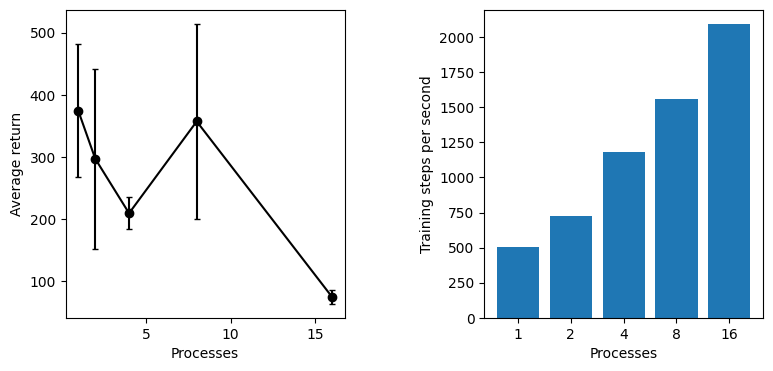

In [35]:
training_steps_per_second = [TRAIN_STEPS / t for t in training_times]

plot_training_results(training_steps_per_second, reward_averages, reward_std)

## Sample efficiency vs wall clock time trade-off
There is clearly a trade-off between sample efficiency, diverse experience and wall clock time. Let's try getting the best performance in a fixed amount of time, say 10 seconds per experiment

In [36]:
SECONDS_PER_EXPERIMENT = 10
steps_per_experiment = [int(SECONDS_PER_EXPERIMENT * fps) for fps in training_steps_per_second]
reward_averages = []
reward_std = []
training_times = []

for n_procs, train_steps in zip(PROCESSES_TO_TEST, steps_per_experiment):
    total_procs += n_procs
    print(f"Running for n_procs = {n_procs} for steps = {train_steps}")
    if n_procs == 1:
        # if there is only one process, there is no need to use multiprocessing
        train_env = DummyVecEnv([lambda: gym.make(env_id)])
    else:
        train_env = SubprocVecEnv([make_env(env_id, i+total_procs) for i in range(n_procs)], start_method="spawn")
        # Alternatively, you can use a DummyVecEnv if the communication delays is the bottleneck
        # train_env = DummyVecEnv([make_env(env_id, i+total_procs) for i in range(n_procs)])

    rewards = []
    times = []

    for experiment in range(NUM_EXPERIMENTS):
        # it is recommended to run several experiments due to variability in results
        train_env.reset()
        model = ALGO("MlpPolicy", train_env, verbose=0)
        start = time.time()
        model.learn(total_timesteps=train_steps)
        times.append(time.time() - start)
        mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=EVAL_EPS)
        rewards.append(mean_reward)

    train_env.close()
    reward_averages.append(np.mean(rewards))
    reward_std.append(np.std(rewards))
    training_times.append(np.mean(times))


Running for n_procs = 1 for steps = 5035
Running for n_procs = 2 for steps = 7246
Running for n_procs = 4 for steps = 11816
Running for n_procs = 8 for steps = 15605
Running for n_procs = 16 for steps = 20912


## Plot the results

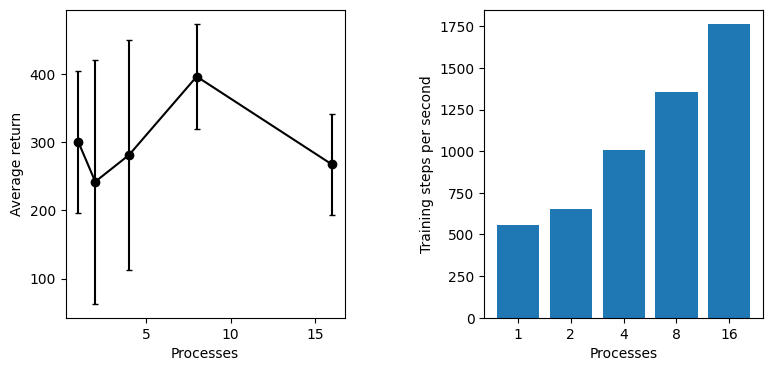

In [37]:
training_steps_per_second = [s / t for s,t in zip(steps_per_experiment, training_times)]

plot_training_results(training_steps_per_second, reward_averages, reward_std)

## DummyVecEnv vs SubprocVecEnv

In [38]:
reward_averages = []
reward_std = []
training_times = []
total_procs = 0
for n_procs in PROCESSES_TO_TEST:
    total_procs += n_procs
    print(f'Running for n_procs = {n_procs}')
    # Here we are using only one process even for n_env > 1
    # this is equivalent to DummyVecEnv([make_env(env_id, i + total_procs) for i in range(n_procs)])
    train_env = make_vec_env(env_id, n_envs=n_procs)

    rewards = []
    times = []

    for experiment in range(NUM_EXPERIMENTS):
        # it is recommended to run several experiments due to variability in results
        train_env.reset()
        model = ALGO("MlpPolicy", train_env, verbose=0)
        start = time.time()
        model.learn(total_timesteps=TRAIN_STEPS)
        times.append(time.time() - start)
        mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=EVAL_EPS)
        rewards.append(mean_reward)

    train_env.close()
    reward_averages.append(np.mean(rewards))
    reward_std.append(np.std(rewards))
    training_times.append(np.mean(times))

Running for n_procs = 1
Running for n_procs = 2
Running for n_procs = 4
Running for n_procs = 8
Running for n_procs = 16


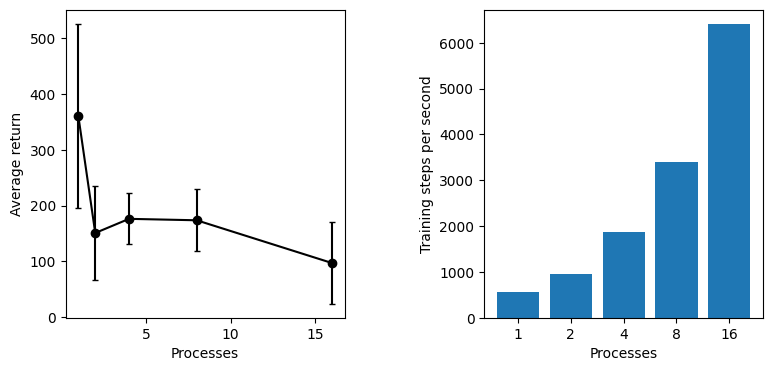

In [39]:
training_steps_per_second = [TRAIN_STEPS / t for t in training_times]

plot_training_results(training_steps_per_second, reward_averages, reward_std)

### What's happening?

It seems that having only one process for n environments is faster in our case.
In practice, the bottleneck does not come from the environment computation, but from synchronisation and communication between processes. To learn more about that problem, you can start [here](https://github.com/hill-a/stable-baselines/issues/322#issuecomment-492202915)

# The importance of hyperparameter tuning

When compared with Supervised Learning, Deep Reinforcement Learning is far more sensitive to the choice of hyper-parameters such as learning rate, number of neurons, number of layers, optimizer ... etc.
Poor choice of hyper-parameters can lead to poor/unstable convergence. This challenge is compounded by the variability in performance across random seeds (used to initialize the network weights and the environment).

Here we demonstrate on a toy example the [Soft Actor Critic](https://arxiv.org/abs/1801.01290) algorithm applied in the Pendulum environment. Note the change in performance between the default and "tuned" parameters.

In [40]:
eval_env = gym.make("Pendulum-v1")

In [41]:
default_model = SAC(
    "MlpPolicy",
    "Pendulum-v1",
    verbose=1,
    seed=0,
    batch_size=64,
    policy_kwargs=dict(net_arch=[64, 64]),
).learn(8000)

Using cpu device
Creating environment from the given name 'Pendulum-v1'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.38e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 94        |
|    time_elapsed    | 8         |
|    total_timesteps | 800       |
| train/             |           |
|    actor_loss      | 18.7      |
|    critic_loss     | 1.46      |
|    ent_coef        | 0.811     |
|    ent_coef_loss   | -0.346    |
|    learning_rate   | 0.0003    |
|    n_updates       | 699       |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.45e+03 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 87        |
|    time_e

In [42]:
mean_reward, std_reward = evaluate_policy(default_model, eval_env, n_eval_episodes=100)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:-402.17 +/- 100.66


In [43]:
tuned_model = SAC(
    "MlpPolicy",
    "Pendulum-v1",
    batch_size=256,
    verbose=1,
    policy_kwargs=dict(net_arch=[256, 256]),
    seed=0,
).learn(8000)

Using cpu device
Creating environment from the given name 'Pendulum-v1'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.38e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 38        |
|    time_elapsed    | 20        |
|    total_timesteps | 800       |
| train/             |           |
|    actor_loss      | 22.5      |
|    critic_loss     | 0.278     |
|    ent_coef        | 0.812     |
|    ent_coef_loss   | -0.34     |
|    learning_rate   | 0.0003    |
|    n_updates       | 699       |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.39e+03 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 36        |
|    time_e

In [44]:
mean_reward, std_reward = evaluate_policy(tuned_model, eval_env, n_eval_episodes=100)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:-135.85 +/- 89.93


Exploring hyperparameter tuning is out of the scope (and time schedule) of this tutorial. However, you need to know that we provide tuned hyperparameter in the [rl zoo](https://github.com/DLR-RM/rl-baselines3-zoo) as well as automatic hyperparameter optimization using [Optuna](https://github.com/pfnet/optuna).
